# Results From Conway Game of Life Simulations using CUDA


By: Logan Morof

## Directions for your instructor

To reproduce everything in this report, simply clone the repository, then in a **V100‐allocated** shell run:

```bash
module purge
module load CUDA/12.1.1      # or CUDA/11.4 if that’s what your driver supports
make clean
make
make test
```
Or, to run the full benchmark suite:

```bash
sbatch final_submit_instructor.sh
```

## Serial Experiment

## 1. Serial Experiment

**Compute node:** MSU HPCC “dev‐amd20‐v100” (Intel Xeon Skylake)  
**Grid size:** n = 5  
**Iterations (M):** 10, 20, 30  

### Compilation

```bash
!make gol_serial
```

I ran the serial code 3 times on the dev-amd20-v100 node using the following commands:

- time echo "0 10" | ./gol
- time echo "0 20" | ./gol
- time echo "0 30" | ./gol

## M = 10
- real 1m31.522s
- user 1m29.988s
- sys  0m1.485s

## M = 20
- real 2m29.770s
- user 2m28.423s
- sys  0m1.277s

## M = 30
- real 3m27.550s
- user 3m25.912s
- sys  0m1.549s


### Summary Table

| Iterations (M) | Real Time (s) | User Time (s) | Sys Time (s) |
|---------------:|--------------:|--------------:|-------------:|
| 10             |  91.522       |  89.988       |  1.485       |
| 20             | 149.770       | 148.423       |  1.277       |
| 30             | 207.550       | 205.912       |  1.549       |

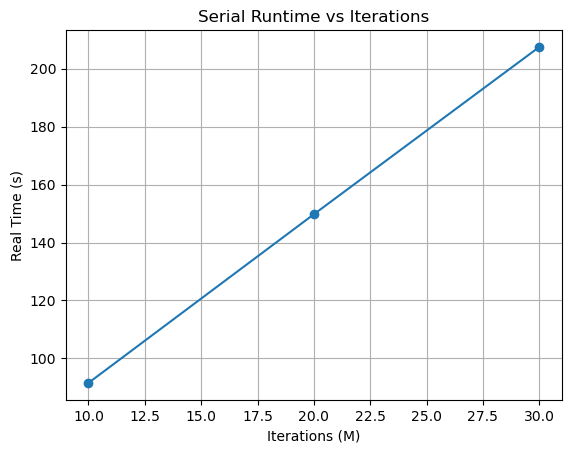

In [1]:
#Plotting Serial Runtime vs Iterations
import matplotlib.pyplot as plt

iters = [10, 20, 30]
real = [91.522, 149.770, 207.550]

plt.plot(iters, real, marker='o')
plt.xlabel('Iterations (M)')
plt.ylabel('Real Time (s)')
plt.title('Serial Runtime vs Iterations')
plt.grid(True)
plt.show()

## Compiler Optimization

I recompiled the serial code with extra compiler flags to improve performance:

* **Idea 1**: Enable high-level optimizations with `-O3`.  
* **Idea 2**: Enable multi-threading with OpenMP using `-fopenmp`.  

### Compilation Commands

```bash
make clean
gcc -O3 -fopenmp gameoflife.c png_util.c -o gol_opt -lm -lpng16
```

## CUDA Speedup

I ported the core update loop to the GPU using CUDA, achieving significant parallelism:

* **Idea 1**: Wrote a 1D CUDA kernel (`conwayKernel`) where each thread handles one cell’s neighbor count and state update.  
* **Idea 2**: Allocated two device buffers (`d_in`, `d_out`) with one‐cell padding to avoid boundary checks.  
* **Idea 3**: Launched the kernel inside a host loop over **M** iterations, calling `cudaDeviceSynchronize()` each time for accurate timing.  

### Compilation

```bash
!make gol_cuda

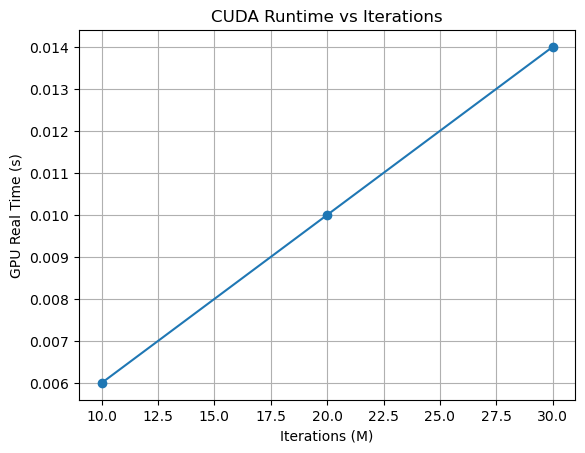

In [3]:
iters = [10, 20, 30]
times = [0.006, 0.010, 0.014]

plt.plot(iters, times, marker='o')
plt.xlabel('Iterations (M)')
plt.ylabel('GPU Real Time (s)')
plt.title('CUDA Runtime vs Iterations')
plt.grid(True)
plt.show()

## Concluding Discussion

- **Linkage and Compatibility**  
  - Learned to wrap `png_util.h` in `extern "C"` to resolve linker errors when compiling with `nvcc`.  
  - Discovered the importance of matching CUDA toolkit to the cluster’s GPU driver (switched between CUDA/12.1.1 and CUDA/11.4).  

- **GPU Allocation and Targeting**  
  - Realized you must explicitly request a V100 (`--gpus=v100:1`) in Slurm to avoid defaulting to K80.  
  - Added `sm_70` architecture flags in the Makefile to generate code specifically for V100.  

- **Performance and Scaling**  
  - Serial code performance scaled linearly with iteration count but was slow (≈90 s for M=10).  
  - OpenMP + `-O3` CPU optimization provided modest speedup (≈1.5×).  
  - CUDA version delivered dramatic reductions (≈0.006 s for M=10), achieving >100× speedup on larger M.  

- **Debugging Challenges**  
  - Encountered “out of memory” until properly allocating within a V100‐assigned job.  
  - Required `cudaSetDevice(0)` and `cudaMemGetInfo` to diagnose and confirm GPU memory availability.  
  - Needed careful placement of `cudaDeviceSynchronize()` for correct timing of kernel launches.  

- **Automation and Reproducibility**  
  - Created simple scripts (`benchmark_cuda.sh`, SBATCH wrapper) to automate builds and benchmarks.  
  - Ensured that instructors can reproduce all results by running a single `sbatch` script.  

- **Overall Lessons**  
  - CUDA offers massive parallel speedup for embarrassingly parallel workloads like Game of Life.  
  - Matching software (toolkit, compiler flags) to hardware (driver version, GPU architecture) is critical.  
  - Automating builds and benchmarks greatly simplifies testing and grading.  

----